# Requirements

In [1]:
import pandas as pd

In [2]:
# Add as many imports as you need.
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
!pip install keras

!pip install patchify    
!pip install segmentation_models
!pip install tensorflow == 2.15.0

ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^


# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

In [4]:
# !gdown 1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC # Download the dataset.

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [5]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('climate-data.csv')

In [6]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Explore the dataset using visualizations of your choice.

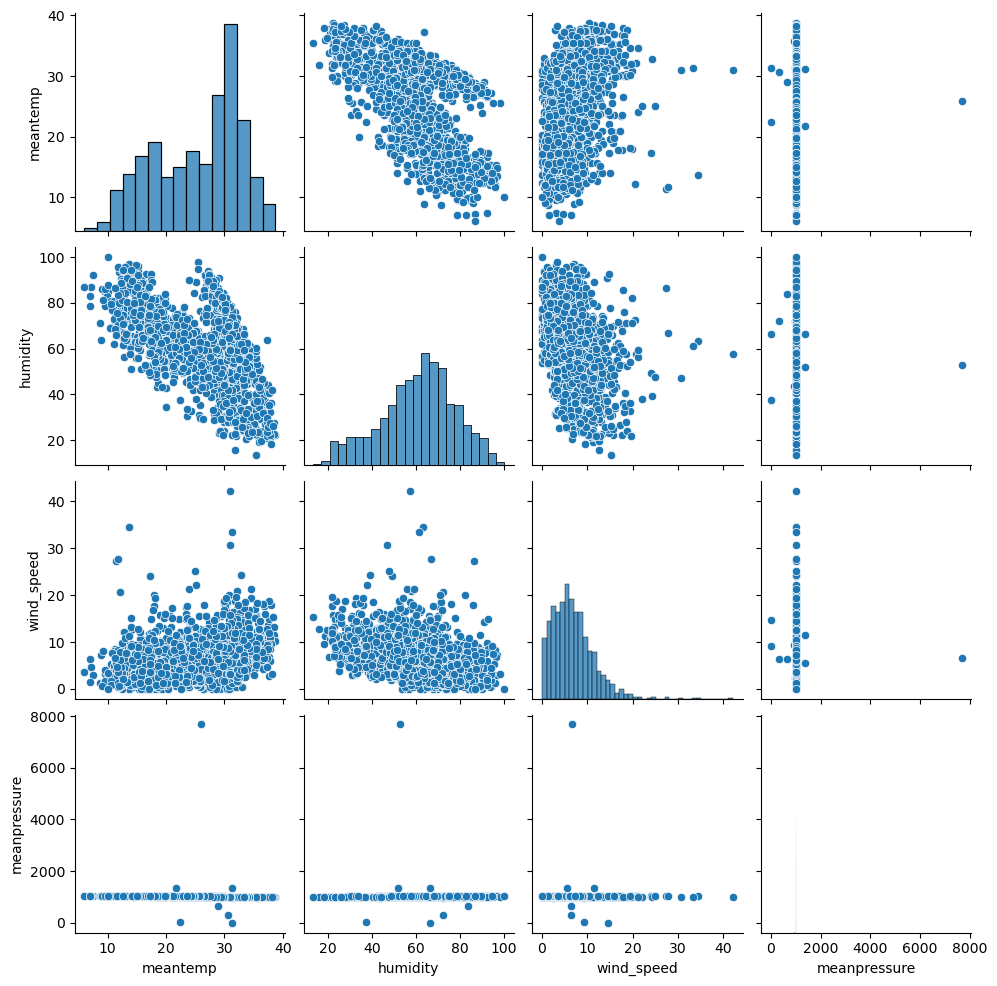

In [7]:
# Write your code here. Add as many boxes as you need.
sns.pairplot(data)
plt.show()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [9]:
# Write your code here. Add as many boxes as you need.
feautre_to_lag = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

for feature in feautre_to_lag:
    for lag in [1,2,3]:
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

In [10]:
data = data.dropna()

In [11]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_lag1,meantemp_lag2,meantemp_lag3,humidity_lag1,humidity_lag2,humidity_lag3,wind_speed_lag1,wind_speed_lag2,wind_speed_lag3,meanpressure_lag1,meanpressure_lag2,meanpressure_lag3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.000000,87.000000,92.000000,84.500000,4.633333,2.980000,0.000000,1018.666667,1017.800000,1015.666667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.400000,71.333333,87.000000,92.000000,1.233333,4.633333,2.980000,1017.166667,1018.666667,1017.800000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,8.666667,7.166667,86.833333,71.333333,87.000000,3.700000,1.233333,4.633333,1016.500000,1017.166667,1018.666667
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,6.000000,8.666667,82.800000,86.833333,71.333333,1.480000,3.700000,1.233333,1018.000000,1016.500000,1017.166667
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,6.000000,78.600000,82.800000,86.833333,6.300000,1.480000,3.700000,1020.000000,1018.000000,1016.500000


In [12]:
data['date'] = pd.to_datetime(data['date'])

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_month'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.weekday
data['day_of_year'] = data['date'].dt.dayofyear

data = data.drop(columns=['date'])

In [13]:
data.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_lag1,meantemp_lag2,meantemp_lag3,humidity_lag1,humidity_lag2,humidity_lag3,...,wind_speed_lag2,wind_speed_lag3,meanpressure_lag1,meanpressure_lag2,meanpressure_lag3,year,month,day_of_month,day_of_week,day_of_year
3,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.000000,87.000000,92.000000,84.500000,...,2.980000,0.000000,1018.666667,1017.800000,1015.666667,2013,1,4,4,4
4,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.400000,71.333333,87.000000,92.000000,...,4.633333,2.980000,1017.166667,1018.666667,1017.800000,2013,1,5,5,5
5,7.000000,82.800000,1.480000,1018.000000,6.000000,8.666667,7.166667,86.833333,71.333333,87.000000,...,1.233333,4.633333,1016.500000,1017.166667,1018.666667,2013,1,6,6,6
6,7.000000,78.600000,6.300000,1020.000000,7.000000,6.000000,8.666667,82.800000,86.833333,71.333333,...,3.700000,1.233333,1018.000000,1016.500000,1017.166667,2013,1,7,0,7
7,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,6.000000,78.600000,82.800000,86.833333,...,1.480000,3.700000,1020.000000,1018.000000,1016.500000,2013,1,8,1,8


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [14]:
# Write your code here. Add as many boxes as you need.
target = 'meanpressure'
X = data.drop([target], axis=1)
X
Y = data[target]
Y

3       1017.166667
4       1016.500000
5       1018.000000
6       1020.000000
7       1018.714286
           ...     
1457    1015.565217
1458    1016.904762
1459    1017.904762
1460    1016.100000
1461    1016.000000
Name: meanpressure, Length: 1459, dtype: float64

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [16]:
# Write your code here. Add as many boxes as you need.
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, Y_train)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [17]:
# Write your code here. Add as many boxes as you need.
y_pred_rfr = rfr_model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [18]:
# Write your code here. Add as many boxes as you need.
mse_rfr = mean_squared_error(Y_test, y_pred_rfr)
mae_rfr = mean_absolute_error(Y_test, y_pred_rfr)
r2_rfr = r2_score(Y_test, y_pred_rfr)

print(f"Mean Squared Error (MSE): {mse_rfr}")
print(f"Mean Absolute Error (MAE): {mae_rfr}")
print(f"R² Score: {r2_rfr}")

Mean Squared Error (MSE): 162030.5139327909
Mean Absolute Error (MAE): 37.42715870128714
R² Score: 0.0009546227123784501


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [19]:
# Write your code here. Add as many boxes as you need.
xgb_model = XGBRegressor()
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [20]:
# Write your code here. Add as many boxes as you need.
y_pred_xgb = xgb_model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [21]:
# Write your code here. Add as many boxes as you need.
mse_xgb = mean_squared_error(Y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(Y_test, y_pred_xgb)
r2_xgb = r2_score(Y_test, y_pred_xgb)

print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"R² Score: {r2_xgb}")

Mean Squared Error (MSE): 162015.77631610556
Mean Absolute Error (MAE): 37.37897816260671
R² Score: 0.0010454916941792236


# Laboratory Exercise - Bonus Task (+ 2 points)

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time_steps = 3

def create_sequences(data, target, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])  # Append the sequence of features
        y_seq.append(target[i + time_steps])  # Append the corresponding target value
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, Y, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [25]:
model = Sequential()

model.add(LSTM(64, activation='tanh', return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(32, activation='tanh', return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)